In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
from datetime import datetime, date, timedelta

# Calibration

This notebook can be used to set the baseline parameters of the model. It generates the base parameter.json file that is used for all simulations.

## 1 Set the general simulation parameters 

In [2]:
i = 0
TIME = 350
AGENTS = 100000 
CITY = ['cape_town'][i]
REGION = ['Western Cape'][i]
POPULATIONS2011 = [3740000]
POPULATIONS2019 = [4524000]
INITIAL_DAYS = 7 + 11 # i1 / i2 + c

##  Google mobility data

obtained from https://www.google.com/covid19/mobility/ on the 8th of February

In [54]:
mobility_data = pd.read_csv('general_data/2020_ZA_Region_Mobility_Report.csv')
mobility_data = mobility_data[mobility_data['sub_region_1'] == REGION]
mobility_data.index = [datetime.strptime(x, '%Y-%m-%d') for x in mobility_data['date']]
mobility_data = mobility_data[mobility_data.columns[9:]].astype(float)

### Excess fatalities

obtained from https://www.samrc.ac.za/reports/report-weekly-deaths-south-africa on January 2nd 2021

In [55]:
ef_ct = pd.read_excel('general_data/Estimated deaths 1+ yrs for SA 30 Jan2021 with adj2.xlsx', sheet_name='Weekly excesses', header=2)
ef_ct['dates'] = ef_ct['Unnamed: 0']
ef_ct.index = ef_ct['dates']

In [56]:
cpt_weekly_excess_fatalities = ef_ct['CPT'].iloc[1:-2]
cpt_weekly_excess_fatalities = cpt_weekly_excess_fatalities[:39]

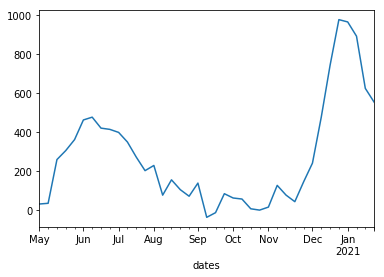

In [57]:
cpt_weekly_excess_fatalities.plot()

Transform to daily data: 

In [58]:
daily_fatalities = []
days = []
for i, x in enumerate(cpt_weekly_excess_fatalities):
    for y in range(7):
        #print(y)
        daily_fatalities.append(x / 7)
        days.append(cpt_weekly_excess_fatalities.index[i] + timedelta(days= y))

In [59]:
excess_fatalities = pd.Series(daily_fatalities)
excess_fatalities.index = days

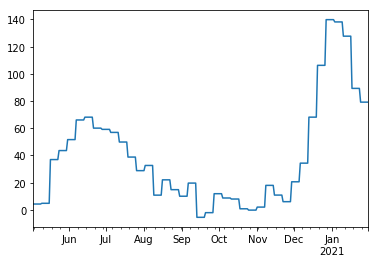

In [60]:
excess_fatalities.plot()

## Combine fatalities and mobility

In [61]:
first_wave_previous_mobility = (100 + (mobility_data.mean(axis=1))).loc[:excess_fatalities.index[0]].iloc[-INITIAL_DAYS:]
first_wave_previous_mobility

2020-04-16    52.2
2020-04-17    52.0
2020-04-18    50.4
2020-04-19    48.4
2020-04-20    49.2
2020-04-21    50.2
2020-04-22    50.6
2020-04-23    51.0
2020-04-24    52.6
2020-04-25    53.4
2020-04-26    51.4
2020-04-27    46.8
2020-04-28    52.6
2020-04-29    53.4
2020-04-30    55.8
2020-05-01    53.4
2020-05-02    59.4
2020-05-03    55.6
dtype: float64

In [62]:
mobility = (100 + (mobility_data.mean(axis=1))).loc[excess_fatalities.index[0]:excess_fatalities.index[-1]]

In [63]:
mobility_and_fatalities = pd.concat([mobility, excess_fatalities], axis=1)
mobility_and_fatalities.columns = ['mobility', 'fatalities']

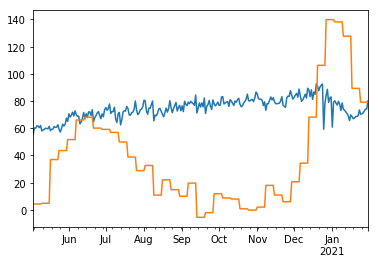

In [64]:
mobility_and_fatalities['mobility'].plot()
mobility_and_fatalities['fatalities'].plot()

# Determine the end of the first wave, and start of the second wave
The first wave ends when excess fatalities < 0 

In [65]:
mobility_and_fatalities.index[0]

Timestamp('2020-05-03 00:00:00')

In [66]:
first_wave_end_date = mobility_and_fatalities.index[0]

for x in range(len(mobility_and_fatalities)):
    if mobility_and_fatalities['fatalities'].loc[first_wave_end_date] > 0:
        first_wave_end_date = first_wave_end_date + timedelta(days=1)
    else:
        break

In [67]:
first_wave_end_date

Timestamp('2020-09-13 00:00:00')

The second wave begins when excess fatalities > 0

In [68]:
second_wave_start_date = mobility_and_fatalities.index[-1]

for x in range(len(mobility_and_fatalities), 0, -1):
    if mobility_and_fatalities['fatalities'].loc[second_wave_start_date] > 0:
        second_wave_start_date = second_wave_start_date - timedelta(days=1)
    else:
        break

In [69]:
second_wave_start_date 

Timestamp('2020-10-31 00:00:00')

## Split datasets

In [70]:
first_wave_data = mobility_and_fatalities.loc[:first_wave_end_date - timedelta(days=1)]

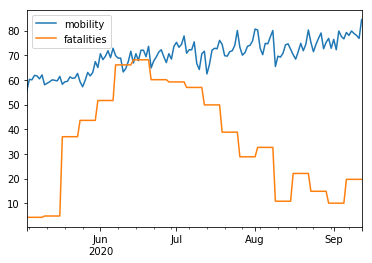

In [71]:
first_wave_data.plot()

In [72]:
second_wave_data = mobility_and_fatalities.loc[second_wave_start_date + timedelta(days=1):]

In [73]:
second_wave_previous_mobility = mobility_and_fatalities.loc[:second_wave_start_date].iloc[-INITIAL_DAYS:]['mobility']
second_wave_previous_mobility

2020-10-14    80.0
2020-10-15    79.0
2020-10-16    81.0
2020-10-17    82.0
2020-10-18    77.6
2020-10-19    75.8
2020-10-20    76.4
2020-10-21    78.6
2020-10-22    79.6
2020-10-23    81.4
2020-10-24    85.0
2020-10-25    80.2
2020-10-26    80.0
2020-10-27    80.8
2020-10-28    81.2
2020-10-29    79.6
2020-10-30    82.0
2020-10-31    86.6
Name: mobility, dtype: float64

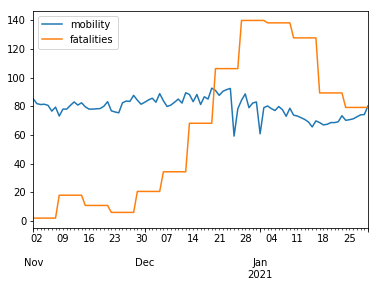

In [74]:
second_wave_data.plot()

### Age groups & health system capacity

The age groups are per decile. 

In [75]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

Health system capacity city 

In [76]:
beds_cape_town = 0.0009179

## Set base parameters

In [77]:
parameters = {
    # Parameters related to model implementation
    "time": len(mobility_and_fatalities), 
    "number_of_agents": AGENTS,
    
    # COVID-19 parameters (9)
    "exposed_days": 4, # (not changed) average number of days before being able to infect others (sources: NICD + CDC)
    "asymptom_days": 7, # (used to be 10) average number of days agents are infected but do not have symptoms 
    "symptom_days": 7,# (used to be 10) average number of days agents with mild symptoms are infectious (NICD = 7, Balabdaoui and Mohr = 8, Huang et al=7)
    "critical_days": 11, # (used to be 8) average number of days agents are in critical condition (Balabdaoui and Mohr = 8, NICD=8-19 (13.5), CDC=10-14 (12))
    "probability_symptomatic": (1 - 0.6165), # (not changed) determines whether an agent will become asymptomatic or asymptomatic spreader
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.02090209, 0.032569361, 0.034233668, 0.052638239, 0.097470817, 0.155112718, 0.248512233, 0.306164902, 0.371187541])}, #used to be [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, probability to die per age group in critical stage SOURCE: Verity et al.
    
    # Cape Town specific parameters
    "health_system_capacity": beds_cape_town,
    "stringency_index": [100 - x for x in mobility_and_fatalities['mobility']],

    # uncertain parameters placeholders
    "total_initial_infections": 100, # total agents infected in CT
    "probability_transmission": 0.01610378740708691, # the probability that the virus is transmitted when two agents interact
    "probability_multiplier_asymptomatic": 0.25,
    
    # parameters used for comparing to data
    'empirical_population': POPULATIONS2011[0],  # specifies the population for the city that is modelled. 
    'empirical_fatalities': list(mobility_and_fatalities['fatalities']),  # 
    
    # SABCoM parameters not used for the estimation
    "visiting_recurring_contacts_multiplier": 0.0, # this disables the compliance feature 
    "probability_susceptible": (4000/1100000) / 246, # probability that the agent will again be susceptible after having recovered
    'private_shock_stdev': 0.05,  # the standard deviation for a truncated normal distribution shock that is part of the private signal for the deGroot learning used by the agents. 
    'weight_private_signal': 1.0,# 0.15,  # the weight of the private signal vis à vis the social signal, used in the deGroot learning process.
    'time_4_new_infections': -1, # -1 is never
    'new_infections_scenario': 'None', # determines where the initial infections will be if either initial (infections will pop up in the same place as initially), or random (infections pop up in random districts). Alternatively, this parameter is None and then no second re-seeding will occur. 
    "informality_dummy": 1.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    'init_infected_agent': 0, # to calculate R0
    "data_output": 'csv-light', # 'csv', 'csv-light' or 'network', or 'False'
    "learning_scenario": None
}

In [78]:
print(parameters["probability_susceptible"])

1.4781966001478197e-05


## Next, we update these parameters and store them in a .json file for both waves

#### Wave 1:

In [79]:
# update time
parameters['time'] = len(first_wave_data) + INITIAL_DAYS
# update mobility 
parameters["stringency_index"] = [100 - x for x in list(first_wave_previous_mobility) + list(first_wave_data['mobility'])]
# update fatalities
parameters['empirical_fatalities'] = [0.0 for x in range(len(first_wave_previous_mobility))] + list(first_wave_data['fatalities'])

In [80]:
with open('{}/first_waveparameters.json'.format(CITY), 'w') as outfile:
    json.dump(parameters, outfile)

### Wave 2:

In [81]:
# update time
parameters['time'] = len(second_wave_data) + INITIAL_DAYS
# update mobility 
parameters["stringency_index"] = [100 - x for x in list(second_wave_previous_mobility) + list(second_wave_data['mobility'])]
# update fatalities
parameters['empirical_fatalities'] = [0.0 for x in range(len(second_wave_previous_mobility))] + list(second_wave_data['fatalities'])

In [82]:
with open('{}/second_waveparameters.json'.format(CITY), 'w') as outfile:
    json.dump(parameters, outfile)

# Smooth 

In [3]:
data = pd.read_csv('output_data/second_strain/seed0quantities_state_time.csv')

In [5]:
infections = data['i1'] + data['i2']

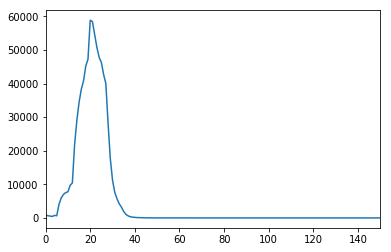

In [6]:
infections.plot()

In [ ]:
sim_dead_curve.diff().ewm(span=10).mean()